# Example for processing a WDM signal with one polarisation
Here will be step by step example of processing a WDM signal with one polarisation.
You need just to run all cells in order.
There will be additional comments what is going on in each cell.

## Importing libraries and setting up the environment

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from prettytable import PrettyTable
from scipy.fft import fftshift, ifftshift, fft, ifft

import hpcom
from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter
from hpcom.channel import create_channel_parameters

# from ssfm_gpu.propagation import propagate_manakov, dispersion_compensation_manakov
from ssfm_gpu.propagation import propagate_schrodinger, dispersion_compensation
from ssfm_gpu.conversion import convert_forward, convert_inverse

import signal_handling.processing as prcs
import tools.functions as fn

import FNFTpy as fpy
import PJTpy as pjt

reload(prcs)
reload(hpcom)

from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter

Allocate GPU memory

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-15 19:46:37.861913: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-15 19:46:37.862507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-15 19:46:37.901138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 19:46:37.901507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-05-15 19:46:37.901524: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-15 19:46:37.902372: I tensorflow/stream_executor/p

## Setting up the parameters of signal and channel

In [4]:
wdm = create_wdm_parameters(n_channels=1,
                            p_ave_dbm=3,
                            n_symbols=2 ** 16,
                            m_order=16,
                            roll_off=0.1,
                            upsampling=4,
                            downsampling_rate=1,
                            symb_freq=34e9,
                            channel_spacing=75e9,
                            n_polarisations=1,
                            seed='fixed')

channel = create_channel_parameters(n_spans=12,
                                    z_span=80,
                                    alpha_db=0.0,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

name_set = fn.form_name(wdm, channel)
print(name_set)

_16qam_34gbd_12spans_80km


In [5]:
signal_x, wdm_info = generate_wdm(wdm)
points_x_orig = wdm_info['points_x'][0]
ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel

2023-05-15 19:51:36.509855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-05-15 19:53:23.243437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [6]:
start_time = datetime.now()
signal_prop = propagate_schrodinger(channel, signal_x, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

propagation took 1154.455 ms


In [22]:
signal_cdc = dispersion_compensation(channel, signal_prop, 1. / wdm['sample_freq'])
points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_cdc, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
print(shift_factor_x, np.absolute(shift_factor_x))

(-0.14671987457290264+1.268369454074717j) 1.2768272371877427


In [8]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 256
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

In [9]:
# create array to store all recovered points
points_all = np.array([])
points_all_nft = np.array([])

## Signal windowing
<a id='signal_windowing'></a>

In [10]:
# cut the Tx and Rx signals to the size of the window
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal_prop, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)
signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal(signal_x, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

## NFT processing

Convert signal to dimensionless form

In [11]:
convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                 channel['beta2'],
                                 channel['gamma'],
                                 t0=1. / wdm['symb_freq'], type='nlse')

q_windowed_cdc = convert_result['q']
t_dl_window_cdc = convert_result['t']
dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
z_span_dimless = convert_result['z']
z_dimless = z_span_dimless * channel['n_spans']

Arrange parameters for the transformation

In [12]:
t = (np.arange(len(signal_prop)) - len(signal_prop) / 2) / wdm['sample_freq']
n_t = len(t_dl_window_cdc)
t_span = t[-1] - t[0]

# shift time to shift signal in the center of the time interval
t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

# arrange nonlinear frequency grid \xi
xi_upsampling = 4
n_xi = xi_upsampling * n_t
rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)

Forward and inverse NFT

In [13]:
# Forward NFT
fnft_type=11

start_time = datetime.now()
result_nlse = fpy.nsev(q_windowed_cdc, t_for_nft, xi[0], xi[-1], n_xi, dst=2, cst=2, dis=fnft_type, K=2048, display_c_msg=True)
print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
start_time = datetime.now()
result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
# result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

# Nonlinear spectrum evolution
a = result_nlse['cont_a']
b = result_nlse['cont_b']
r = result_nlse['cont_ref']

res = result_pjt

rd = res['disc_res']
bd = res['disc_norm']
xi_d = res['bound_states']
# ad = bd / rd

b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))

# Inverse NFT
start_time = datetime.now()
result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop, cst=1, dst=0)
print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
q_fnft = result_nsev_inverse['q']

FNFT Error: Division by zero.
 in nsev_compute_normconsts_or_residues(1035)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_base(594)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev(342)-0.4.1
/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/FNFTpy/auxiliary.py:159: UserWarning: An error occured when calling FNFT: error code -3
  warn(wstring)


forward NFT took 36830.02 ms
PJT took 211972.039 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 69423.39 ms


Inverse conversion from dimensionless form

In [14]:
convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='nlse')

signal_nft = convert_forward_result['Q']
t_nft = convert_forward_result['T']

Decode constellation points

In [24]:
# add zeros to the end of the signal to process with the same length as the original signal
n_signal_total = len(signal_prop)
signal_nft_complete = np.concatenate([signal_nft, np.zeros(n_signal_total - len(signal_nft))])
signal_nft_complete = tf.cast(signal_nft_complete, tf.complex128)

points_x_nft = get_points_wdm(hpcom.signal.filter_shaper(signal_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

# for NFT processed we have n_symb_add + n_symb_side points from left
n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_nft = range(n_points_start_nft, n_points_end_nft)

# for original signal we have n_symb_skip + n_symb_side points from left
n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_orig = range(n_points_start_orig, n_points_end_orig)

# points_found = scale_p * points_x_window[range_points]
points_found_nft = points_x_nft[range_points_nft]
points_was_orig = points_x_orig[range_points_orig]

# shift and rotate points, if needed
shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_was_orig)), points_was_orig) / np.dot(
    np.transpose(np.conjugate(points_was_orig)), points_found_nft)
points_found_nft *= shift_factor_x_nft
print("shift factor for x:", shift_factor_x_nft, np.absolute(shift_factor_x_nft))

shift factor for x: (-1.8461984408374148+2.037204871926234j) 2.749300342478152


In [19]:
table = PrettyTable()
for k in range(len(points_found_nft)):
    table.add_row(['{:.5f}'.format(points_was_orig[k]),
                   '{:.5f}'.format(points_found_nft[k])])

print(table)

+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
| -0.04238-0.04238j | -0.04312-0.04233j |
|  0.04238-0.04238j |  0.04236-0.04120j |
|  0.01413-0.04238j |  0.01423-0.04439j |
| -0.04238+0.01413j | -0.04360+0.01601j |
| -0.04238-0.01413j | -0.04073-0.01620j |
| -0.01413+0.01413j | -0.01423+0.01467j |
| -0.04238-0.04238j | -0.04209-0.04362j |
|  0.04238+0.01413j |  0.04054+0.01441j |
| -0.01413-0.01413j | -0.01237-0.01435j |
| -0.01413-0.01413j | -0.01490-0.01407j |
| -0.04238+0.01413j | -0.04197+0.01410j |
| -0.04238+0.04238j | -0.04157+0.04332j |
| -0.01413+0.01413j | -0.01421+0.01380j |
| -0.01413-0.01413j | -0.01330-0.01431j |
|  0.01413+0.04238j |  0.01495+0.04014j |
| -0.01413+0.01413j | -0.01449+0.01652j |
+-------------------+-------------------+


Now we can store points and continue signal processing

In [16]:
points_all = np.concatenate([points_all, points_was_orig])
points_all_nft = np.concatenate([points_all_nft, points_found_nft])

Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing

In [17]:
process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']

Go to [Signal windowing](#signal_windowing) section

# Here is the same example but with single function

In [25]:
def example_nlse_processing(wdm, channel, process_parameters):


    signal_x, wdm_info = generate_wdm(wdm)
    points_x_orig = wdm_info['points_x'][0]
    ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel

    start_time = datetime.now()
    signal_prop = propagate_schrodinger(channel, signal_x, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
    print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

    signal_cdc = dispersion_compensation(channel, signal_prop, 1. / wdm['sample_freq'])
    points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_cdc, ft_filter_values)[::wdm['downsampling_rate']],
                                  wdm)  # downsample
    shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(
        np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
    print(shift_factor_x, np.absolute(shift_factor_x))


    # create array to store all recovered points
    points = np.array([])
    points_nft = np.array([])


    for _ in range(process_parameters['n_steps']):
        print("Processing iteration", _, "of", process_parameters['n_steps'])  # print step number

        # Signal windowing
        # ----------------
        # cut the Tx and Rx signals to the size of the window
        signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal_prop, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)
        signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal(signal_x, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)


        # Convert signal to dimensionless form
        # ------------------------------------
        convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                     channel['beta2'],
                                     channel['gamma'],
                                     t0=1. / wdm['symb_freq'], type='nlse')

        q_windowed_cdc = convert_result['q']
        t_dl_window_cdc = convert_result['t']
        dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
        z_span_dimless = convert_result['z']
        z_dimless = z_span_dimless * channel['n_spans']


        # Arrange parameters for the transformation
        # -----------------------------------------
        t = (np.arange(len(signal_prop)) - len(signal_prop) / 2) / wdm['sample_freq']
        n_t = len(t_dl_window_cdc)
        t_span = t[-1] - t[0]

        # shift time to shift signal in the center of the time interval
        t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

        # arrange nonlinear frequency grid \xi
        xi_upsampling = 4
        n_xi = xi_upsampling * n_t
        rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
        xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)


        # Forward NFT
        # -----------
        fnft_type=11

        start_time = datetime.now()
        result_nlse = fpy.nsev(q_windowed_cdc, t_for_nft, xi[0], xi[-1], n_xi, dst=2, cst=2, dis=fnft_type, K=2048, display_c_msg=True)
        print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
        start_time = datetime.now()
        result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
        # result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
        print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")


        # Nonlinear spectrum evolution
        # ----------------------------
        a = result_nlse['cont_a']
        b = result_nlse['cont_b']
        r = result_nlse['cont_ref']

        res = result_pjt

        rd = res['disc_res']
        bd = res['disc_norm']
        xi_d = res['bound_states']
        # ad = bd / rd

        b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
        bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))


        # Inverse NFT
        # -----------
        start_time = datetime.now()
        result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop, cst=1, dst=0)
        print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
        q_fnft = result_nsev_inverse['q']


        # Inverse conversion from dimensionless form
        # ------------------------------------------
        convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                             channel['beta2'],
                                             channel['gamma'],
                                             t0=1. / wdm['symb_freq'], type='nlse')

        signal_nft = convert_forward_result['Q']
        t_nft = convert_forward_result['T']


        # Decode constellation points
        # ---------------------------
        # add zeros to the end of the signal to process with the same length as the original signal
        n_signal_total = len(signal_prop)
        signal_nft_complete = np.concatenate([signal_nft, np.zeros(n_signal_total - len(signal_nft))])
        signal_nft_complete = tf.cast(signal_nft_complete, tf.complex128)

        points_x_nft = get_points_wdm(hpcom.signal.filter_shaper(signal_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

        # for NFT processed we have n_symb_add + n_symb_side points from left
        n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
        n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_nft = range(n_points_start_nft, n_points_end_nft)

        # for original signal we have n_symb_skip + n_symb_side points from left
        n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
        n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_orig = range(n_points_start_orig, n_points_end_orig)

        # points_found = scale_p * points_x_window[range_points]
        points_found_nft = points_x_nft[range_points_nft]
        points_was_orig = points_x_orig[range_points_orig]

        # shift and rotate points, if needed
        shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_was_orig)), points_was_orig) / np.dot(
            np.transpose(np.conjugate(points_was_orig)), points_found_nft)
        points_found_nft *= shift_factor_x_nft
        print("shift factor for x:", shift_factor_x_nft)


        # Now we can store points and continue signal processing
        # ------------------------------------------------------
        points = np.concatenate([points, points_was_orig])
        points_nft = np.concatenate([points_nft, points_found_nft])


        # Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing
        process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']


    return points, points_nft

In [32]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
process_parameters['n_steps'] = 256
process_parameters['n_symb_proc'] = 32
process_parameters['n_symb_side'] = 300
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

points, points_nft = example_nlse_processing(wdm, channel, process_parameters)

propagation took 1109.652 ms
(-0.14671987457290264+1.268369454074717j) 1.2768272371877427
Processing iteration 0 of 256
forward NFT took 5087.205 ms
PJT took 9915.414999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1956.826 ms
shift factor for x: (0.9981785816252879+0.00822443938127081j)
Processing iteration 1 of 256
forward NFT took 4979.785 ms
PJT took 9086.256000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2010.0950000000003 ms
shift factor for x: (0.9996589713309991-0.00487351238686422j)
Processing iteration 2 of 256
forward NFT took 5031.145 ms
PJT took 9993.804 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1871.095 ms
shift factor for x: (1.0016143711782108-0.0012932379625512735j)
Processing iteration 3 of 256
forward NFT took 5218.171 ms
PJT took 8896.873 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1944.0839999999998 ms
shift factor for x: (0.9990697903713858+0.007079713419016551j)
Processing iteration 4 of 256
forward NFT took 5179.058999999999 ms
PJT took 9278.33 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1942.856 ms
shift factor for x: (1.001188606571143+0.007944109623979411j)
Processing iteration 5 of 256
forward NFT took 5123.126 ms
PJT took 10038.117 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1876.082 ms
shift factor for x: (1.0019928409513372+0.0021084716511368287j)
Processing iteration 6 of 256
forward NFT took 4969.891 ms
PJT took 8631.012999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1903.651 ms
shift factor for x: (0.9991656426499652+0.00044602058494142704j)
Processing iteration 7 of 256
forward NFT took 5136.202 ms
PJT took 9217.408000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1922.108 ms
shift factor for x: (0.996909861218239+0.010024504665617204j)
Processing iteration 8 of 256
forward NFT took 5063.723999999999 ms
PJT took 9166.842 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1899.287 ms
shift factor for x: (0.9984400728620169+0.006179049285735243j)
Processing iteration 9 of 256
forward NFT took 5077.458 ms
PJT took 9187.386 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1904.3890000000001 ms
shift factor for x: (0.9998320641909351+0.006612095228412298j)
Processing iteration 10 of 256
forward NFT took 5125.3679999999995 ms
PJT took 9262.207 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1819.9840000000002 ms
shift factor for x: (1.0004851656828206+0.003423057812241891j)
Processing iteration 11 of 256
forward NFT took 5156.244 ms
PJT took 9674.965 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1934.526 ms
shift factor for x: (1.00076859758828+0.008358908152501477j)
Processing iteration 12 of 256
forward NFT took 5031.026 ms
PJT took 9241.718 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1918.992 ms
shift factor for x: (1.0008707687832352+0.001466782493367336j)
Processing iteration 13 of 256
forward NFT took 5108.3460000000005 ms
PJT took 9898.942 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1869.225 ms
shift factor for x: (0.998109450675426+0.0038484051968171395j)
Processing iteration 14 of 256
forward NFT took 5118.519 ms
PJT took 9406.679 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1916.742 ms
shift factor for x: (1.0000230969702082-0.005234963417143179j)
Processing iteration 15 of 256
forward NFT took 5098.387 ms
PJT took 9065.9 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1824.577 ms
shift factor for x: (1.1379649111873447-0.19111556895775422j)
Processing iteration 16 of 256
forward NFT took 4981.099 ms
PJT took 10325.689 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1959.864 ms
shift factor for x: (0.9980190951306512+0.004523019486042559j)
Processing iteration 17 of 256
forward NFT took 5237.164 ms
PJT took 9455.219 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1941.398 ms
shift factor for x: (1.0019794403438678+0.004989322210575444j)
Processing iteration 18 of 256
forward NFT took 5032.066000000001 ms
PJT took 10034.011 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1970.2649999999999 ms
shift factor for x: (1.0000443348332686-0.0028019138519697877j)
Processing iteration 19 of 256
forward NFT took 5097.821 ms
PJT took 9273.671999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2004.2089999999998 ms
shift factor for x: (1.0032199663421435+0.006158394027609621j)
Processing iteration 20 of 256
forward NFT took 5046.57 ms
PJT took 9699.516 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1864.2920000000001 ms
shift factor for x: (1.001447740377829-0.007990270299833865j)
Processing iteration 21 of 256
forward NFT took 5136.335 ms
PJT took 10911.224 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1794.5420000000001 ms
shift factor for x: (1.0005026427487471-0.007592260113483832j)
Processing iteration 22 of 256
forward NFT took 5129.991999999999 ms
PJT took 10793.789999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1890.812 ms
shift factor for x: (1.0012678288220507+0.0013868871188171682j)
Processing iteration 23 of 256
forward NFT took 4958.216 ms
PJT took 9068.009999999998 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1876.283 ms
shift factor for x: (0.999944955213272+0.010727708773500922j)
Processing iteration 24 of 256
forward NFT took 5104.262000000001 ms
PJT took 9774.060000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1931.286 ms
shift factor for x: (0.9997867948381285+0.0038566672396934884j)
Processing iteration 25 of 256
forward NFT took 5228.982 ms
PJT took 9563.518 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1873.3519999999999 ms
shift factor for x: (1.0000033037250178+0.0030484582623179005j)
Processing iteration 26 of 256
forward NFT took 5105.875 ms
ERASING2 (1.25584,0.083162)
PJT took 13096.963 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1883.836 ms
shift factor for x: (1.0017785244829345-0.0013791604346030655j)
Processing iteration 27 of 256
forward NFT took 5132.864 ms
ERASING2 (1.40183,0.0256942)
PJT took 9899.378 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1833.4470000000001 ms
shift factor for x: (1.000039691762763+0.0064183148732338885j)
Processing iteration 28 of 256
forward NFT took 5095.308 ms
PJT took 9637.184 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1982.675 ms
shift factor for x: (0.9990971094583414+0.0028905970201083377j)
Processing iteration 29 of 256
forward NFT took 5065.8279999999995 ms
PJT took 9276.234 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1916.0040000000001 ms
shift factor for x: (1.001707586173361+0.0021039572111542153j)
Processing iteration 30 of 256
forward NFT took 4985.591 ms
PJT took 9691.202000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1906.979 ms
shift factor for x: (1.0027234217902523+0.006335288163231735j)
Processing iteration 31 of 256
forward NFT took 5145.648 ms
ERASING2 (0.713378,0.0801505)
PJT took 11049.97 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1860.29 ms
shift factor for x: (1.0012141451258951+0.0042607431314127j)
Processing iteration 32 of 256
forward NFT took 5103.922 ms
PJT took 9097.534 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1884.579 ms
shift factor for x: (1.0022335981926362-0.000881388113373725j)
Processing iteration 33 of 256
forward NFT took 5092.273999999999 ms
PJT took 9467.681 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1917.073 ms
shift factor for x: (0.9991127075331435-0.0014143025861862305j)
Processing iteration 34 of 256
forward NFT took 5088.258 ms
ERASING2 (-1.19912,0.127195)
PJT took 11161.105 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1906.474 ms
shift factor for x: (1.0001257739055762+0.010650132492325324j)
Processing iteration 35 of 256
forward NFT took 5191.572 ms
PJT took 9550.852 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1935.4199999999998 ms
shift factor for x: (1.000935031222678+0.004616013515230761j)
Processing iteration 36 of 256
forward NFT took 5089.014999999999 ms
PJT took 9562.301 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1903.38 ms
shift factor for x: (0.9981348898016839+0.009765147586564377j)
Processing iteration 37 of 256
forward NFT took 5158.86 ms
ERASING2 (0.723502,0.0502379)
PJT took 9261.317000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1973.114 ms
shift factor for x: (0.9988951661891441-0.0010258957269478352j)
Processing iteration 38 of 256
forward NFT took 5074.7609999999995 ms
ERASING1 (-1.1024,0.120303)
PJT took 9419.023 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2001.7350000000001 ms
shift factor for x: (0.9999963572362155+0.000637933259323652j)
Processing iteration 39 of 256
forward NFT took 5081.186 ms
PJT took 9634.61 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1862.627 ms
shift factor for x: (1.0038628923329544+0.001153077459105878j)
Processing iteration 40 of 256
forward NFT took 4997.243 ms
PJT took 9545.645 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1935.2549999999999 ms
shift factor for x: (1.0005555097157115+0.003563656965583717j)
Processing iteration 41 of 256
forward NFT took 4969.979 ms
PJT took 8604.423 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1885.0990000000002 ms
shift factor for x: (0.9973722684990332-0.006247524158832306j)
Processing iteration 42 of 256
forward NFT took 5140.996 ms
PJT took 8860.392 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1908.9959999999999 ms
shift factor for x: (0.997378127989903+0.0060370654106354435j)
Processing iteration 43 of 256
forward NFT took 5111.945000000001 ms
PJT took 9901.636 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2003.4969999999998 ms
shift factor for x: (1.0003743492828048+0.0051932452385643965j)
Processing iteration 44 of 256
forward NFT took 5078.349 ms
PJT took 8768.063 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1932.2189999999998 ms
shift factor for x: (1.000056153878108+0.006201786707803411j)
Processing iteration 45 of 256
forward NFT took 5076.027 ms
PJT took 9720.624000000002 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2014.3490000000002 ms
shift factor for x: (1.0032124607246755+0.018458993982064225j)
Processing iteration 46 of 256
forward NFT took 5050.5019999999995 ms
PJT took 9219.131000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1873.379 ms
shift factor for x: (0.998963219836393+0.005161130067090457j)
Processing iteration 47 of 256
forward NFT took 5041.472 ms
PJT took 9456.195 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1851.773 ms
shift factor for x: (1.0037116829839332+0.0066033950639159305j)
Processing iteration 48 of 256
forward NFT took 4884.22 ms
PJT took 9786.901 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1940.7179999999998 ms
shift factor for x: (1.0004973026195858+0.005793603034895607j)
Processing iteration 49 of 256
forward NFT took 5053.568 ms
PJT took 9512.015 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1952.658 ms
shift factor for x: (1.002349418101901-0.003958531149136786j)
Processing iteration 50 of 256
forward NFT took 4974.459000000001 ms
PJT took 8894.582 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1960.6760000000002 ms
shift factor for x: (0.9992091358624166+0.0003076827094820467j)
Processing iteration 51 of 256
forward NFT took 4979.83 ms
PJT took 9644.083999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1864.328 ms
shift factor for x: (0.9990513161583674-0.0022278943112654086j)
Processing iteration 52 of 256
forward NFT took 5099.5419999999995 ms
ERASING2 (-0.3239,0.0141893)
PJT took 10712.409 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1868.476 ms
shift factor for x: (1.001135588669365-0.0005080866249886573j)
Processing iteration 53 of 256
forward NFT took 5109.05 ms
PJT took 9994.812 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1879.811 ms
shift factor for x: (1.001716640056447+0.00514617371953672j)
Processing iteration 54 of 256
forward NFT took 5120.8150000000005 ms
PJT took 9065.654999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1964.626 ms
shift factor for x: (0.9976490332237312-0.0013807348257417488j)
Processing iteration 55 of 256
forward NFT took 5138.452 ms
PJT took 9075.846 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1848.3700000000001 ms
shift factor for x: (1.004669044590048+0.0017945019372641723j)
Processing iteration 56 of 256
forward NFT took 5097.016 ms
PJT took 8671.362000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1954.983 ms
shift factor for x: (0.9996506213794507+0.0025167694104095634j)
Processing iteration 57 of 256
forward NFT took 5043.214 ms
PJT took 8457.048 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1958.8719999999998 ms
shift factor for x: (1.0007470890468386+0.003040206115516416j)
Processing iteration 58 of 256
forward NFT took 5074.282 ms
PJT took 8812.405 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1926.5110000000002 ms
shift factor for x: (0.9992292392565975-0.00014497492676748556j)
Processing iteration 59 of 256
forward NFT took 5105.188 ms
ERASING2 (-1.02438,0.164943)
ERASING2 (0.310554,0.0510049)
PJT took 14414.256 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1926.951 ms
shift factor for x: (1.0002691820296117+0.008026980678838717j)
Processing iteration 60 of 256
forward NFT took 5145.361 ms
PJT took 9142.741 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1886.855 ms
shift factor for x: (0.998756625086042-0.005018342553106809j)
Processing iteration 61 of 256
forward NFT took 5118.336 ms
PJT took 8480.705 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1889.1409999999998 ms
shift factor for x: (1.0000042000999296+0.0015609581885323454j)
Processing iteration 62 of 256
forward NFT took 5108.34 ms
PJT took 9172.376 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1919.654 ms
shift factor for x: (1.0015473976558-0.004310762618089653j)
Processing iteration 63 of 256
forward NFT took 5080.682000000001 ms
PJT took 8972.587000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1936.277 ms
shift factor for x: (1.000500221009653+0.005137796952563637j)
Processing iteration 64 of 256
forward NFT took 5069.844 ms
PJT took 9068.154 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1902.264 ms
shift factor for x: (0.9990529336394632+0.005913037103403943j)
Processing iteration 65 of 256
forward NFT took 5176.049 ms
ERASING2 (0.310248,0.0510049)
PJT took 8919.482 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1812.275 ms
shift factor for x: (1.0009503827224995+0.00640278487651675j)
Processing iteration 66 of 256
forward NFT took 5045.839 ms
PJT took 8835.108999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1858.961 ms
shift factor for x: (1.0025929056541942+0.004313581223027124j)
Processing iteration 67 of 256
forward NFT took 5103.058 ms
PJT took 9420.987000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1967.337 ms
shift factor for x: (1.0006105863662882+0.0077212454943560134j)
Processing iteration 68 of 256
forward NFT took 5096.604 ms
PJT took 9118.073 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1944.987 ms
shift factor for x: (1.0006983232958484-0.0018104557421405082j)
Processing iteration 69 of 256
forward NFT took 5234.787 ms
PJT took 8668.447 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1881.3500000000001 ms
shift factor for x: (0.9987431287378281-0.004601639826290771j)
Processing iteration 70 of 256
forward NFT took 5195.467 ms
PJT took 9310.212 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1903.4850000000001 ms
shift factor for x: (1.0003496819401043+0.0024847021153902903j)
Processing iteration 71 of 256
forward NFT took 5194.198 ms
PJT took 10093.84 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1902.128 ms
shift factor for x: (1.0002122528020978+0.0019201881303643241j)
Processing iteration 72 of 256
forward NFT took 5160.585 ms
PJT took 9867.951 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1892.314 ms
shift factor for x: (1.0020967384037767-0.0021376131114365796j)
Processing iteration 73 of 256
forward NFT took 5157.56 ms
PJT took 9396.104 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1952.8419999999999 ms
shift factor for x: (0.9994165249140322+0.009531582644795698j)
Processing iteration 74 of 256
forward NFT took 5147.586 ms
PJT took 10024.282 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1894.687 ms
shift factor for x: (1.003729560610464+1.206950470059509e-05j)
Processing iteration 75 of 256
forward NFT took 5093.799 ms
PJT took 9653.301000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1898.487 ms
shift factor for x: (1.0002887965557963-0.005283455394887636j)
Processing iteration 76 of 256
forward NFT took 5093.51 ms
PJT took 9654.402 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1860.346 ms
shift factor for x: (1.0021069975083612+0.0023997104176349793j)
Processing iteration 77 of 256
forward NFT took 5013.924 ms
PJT took 9516.444 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1892.541 ms
shift factor for x: (1.0009105047118447+0.0022790323013188772j)
Processing iteration 78 of 256
forward NFT took 4956.874 ms
PJT took 10364.24 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1925.9250000000002 ms
shift factor for x: (1.0037442671270156+0.00597164613055278j)
Processing iteration 79 of 256
forward NFT took 5235.906 ms
PJT took 9797.792 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1871.378 ms
shift factor for x: (0.9995030843861676+0.0012383233239915813j)
Processing iteration 80 of 256
forward NFT took 5214.715 ms
PJT took 9370.756 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1850.287 ms
shift factor for x: (1.002418272857988+0.006846494727433498j)
Processing iteration 81 of 256
forward NFT took 5100.087 ms
PJT took 8587.598 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1874.729 ms
shift factor for x: (1.0009545918409752+0.003566906884679459j)
Processing iteration 82 of 256
forward NFT took 5003.848 ms
PJT took 9568.037 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1873.421 ms
shift factor for x: (0.9990357602428324+0.004378273072194916j)
Processing iteration 83 of 256
forward NFT took 5171.311000000001 ms
PJT took 8881.93 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1881.747 ms
shift factor for x: (1.002038844721018+0.01336439846519708j)
Processing iteration 84 of 256
forward NFT took 5125.57 ms
PJT took 10105.516 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2006.9279999999999 ms
shift factor for x: (0.9982720833048798-0.0029475989103570177j)
Processing iteration 85 of 256
forward NFT took 5001.786 ms
PJT took 9465.25 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1884.182 ms
shift factor for x: (1.0004707851405423-0.003924691257111618j)
Processing iteration 86 of 256
forward NFT took 5107.678 ms
PJT took 9925.032 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1824.373 ms
shift factor for x: (1.0023385036471835+0.0037207564543291264j)
Processing iteration 87 of 256
forward NFT took 5158.465999999999 ms
PJT took 9409.324 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1985.445 ms
shift factor for x: (0.998829128948707+0.01128590230799714j)
Processing iteration 88 of 256
forward NFT took 5063.551 ms
ERASING2 (0.928749,0.0519976)
PJT took 10167.14 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1865.226 ms
shift factor for x: (0.998089725804798+0.005625645834941409j)
Processing iteration 89 of 256
forward NFT took 4981.548 ms
PJT took 10147.18 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1934.893 ms
shift factor for x: (0.9976872564431672-0.007751951972955067j)
Processing iteration 90 of 256
forward NFT took 5070.1 ms
PJT took 8709.521999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1923.4560000000001 ms
shift factor for x: (0.9981729854444333+0.004244932942303829j)
Processing iteration 91 of 256
forward NFT took 5103.183 ms
PJT took 8503.574999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1866.6490000000001 ms
shift factor for x: (1.003556761242113+0.003947232884109482j)
Processing iteration 92 of 256
forward NFT took 5033.092 ms
PJT took 8876.926 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1882.279 ms
shift factor for x: (0.9957553934006311+0.005846606998489977j)
Processing iteration 93 of 256
forward NFT took 5062.6939999999995 ms
PJT took 9470.912 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1858.271 ms
shift factor for x: (1.0624498512066247-0.24543638917622296j)
Processing iteration 94 of 256
forward NFT took 5144.201 ms
PJT took 9722.737000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1974.182 ms
shift factor for x: (1.001308741104195+0.009359946745869896j)
Processing iteration 95 of 256
forward NFT took 5104.449 ms
PJT took 9658.172999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1915.7839999999999 ms
shift factor for x: (1.0000678730894788-0.011666430165667303j)
Processing iteration 96 of 256
forward NFT took 5079.053 ms
PJT took 9968.491 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1843.1 ms
shift factor for x: (1.0034619255545243+0.009040719403220305j)
Processing iteration 97 of 256
forward NFT took 5028.157 ms
PJT took 9542.203000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1908.122 ms
shift factor for x: (1.000888074286269-0.00645559459212014j)
Processing iteration 98 of 256
forward NFT took 5082.905000000001 ms
PJT took 9829.909000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1863.8220000000001 ms
shift factor for x: (1.0019334692415258-0.009000221457588824j)
Processing iteration 99 of 256
forward NFT took 5185.145 ms
PJT took 10410.224 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1948.451 ms
shift factor for x: (0.999622598063877+0.005671404748120485j)
Processing iteration 100 of 256
forward NFT took 5213.816 ms
PJT took 9148.624 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1886.112 ms
shift factor for x: (1.003546780832193-0.0022398484970979817j)
Processing iteration 101 of 256
forward NFT took 5071.283 ms
ERASING2 (-0.847149,0.0343504)
PJT took 10350.011999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1861.76 ms
shift factor for x: (1.0014663894660714-0.0026404107408020817j)
Processing iteration 102 of 256
forward NFT took 5144.406 ms
ERASING2 (0.632997,0.00191748)
PJT took 10901.755 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1931.8010000000002 ms
shift factor for x: (1.0018132383047804-0.008002332356494824j)
Processing iteration 103 of 256
forward NFT took 5138.135 ms
PJT took 10060.882 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1877.109 ms
shift factor for x: (0.9991074966304433-0.008040206670822714j)
Processing iteration 104 of 256
forward NFT took 4973.947 ms
PJT took 10180.865000000002 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1915.2610000000002 ms
shift factor for x: (1.002954825250893+0.007260597390424532j)
Processing iteration 105 of 256
forward NFT took 5037.223 ms
PJT took 8945.371 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1982.594 ms
shift factor for x: (0.9969030854287534+0.006253970638134447j)
Processing iteration 106 of 256
forward NFT took 4914.272000000001 ms
ERASING2 (-0.38802,0.0625097)
PJT took 9761.662 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1962.8129999999999 ms
shift factor for x: (1.0004850069455158-0.0013147904362610131j)
Processing iteration 107 of 256
forward NFT took 4897.053 ms
ERASING2 (0.936112,0.0157233)
PJT took 9661.716 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1948.616 ms
shift factor for x: (1.0022869700744157+0.002625909425844326j)
Processing iteration 108 of 256
forward NFT took 5166.331999999999 ms
PJT took 9209.868 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1986.5710000000001 ms
shift factor for x: (1.0005645733597905-0.0004959567364194287j)
Processing iteration 109 of 256
forward NFT took 5110.571 ms
ERASING2 (-1.09404,0.147424)
PJT took 64531.448 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1999.269 ms
shift factor for x: (1.2346174471253422+0.07778617766814956j)
Processing iteration 110 of 256
forward NFT took 5093.187 ms
PJT took 8570.599 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1899.187 ms
shift factor for x: (1.0000963039648967+0.002181080204501435j)
Processing iteration 111 of 256
forward NFT took 5175.097 ms
ERASING2 (-1.04108,0.166391)
PJT took 60140.065 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1911.7340000000002 ms
shift factor for x: (1.3279747965753905+0.08096747193402226j)
Processing iteration 112 of 256
forward NFT took 5132.4839999999995 ms
PJT took 8572.855000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1947.3229999999999 ms
shift factor for x: (0.9995783682964868-0.002668519421645096j)
Processing iteration 113 of 256
forward NFT took 5042.212 ms
PJT took 9358.786 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1849.731 ms
shift factor for x: (1.001210974882762+0.003281897661471226j)
Processing iteration 114 of 256
forward NFT took 5122.854 ms
PJT took 8945.899000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1923.861 ms
shift factor for x: (0.9994567274694228+0.0008773886682371054j)
Processing iteration 115 of 256
forward NFT took 4978.659000000001 ms
PJT took 9075.635 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1824.941 ms
shift factor for x: (1.000257373613651-0.004087329969123791j)
Processing iteration 116 of 256
forward NFT took 4995.931 ms
PJT took 9744.626 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1869.445 ms
shift factor for x: (1.0019599707419875+0.003198699662298403j)
Processing iteration 117 of 256
forward NFT took 5070.313999999999 ms
PJT took 9388.846 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1908.436 ms
shift factor for x: (1.0022127205700258+0.0014344240261065665j)
Processing iteration 118 of 256
forward NFT took 4989.803 ms
PJT took 9156.292000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1828.9189999999999 ms
shift factor for x: (1.0008196044296844+0.0004893882457141827j)
Processing iteration 119 of 256
forward NFT took 5136.409 ms
PJT took 9227.024 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1889.835 ms
shift factor for x: (0.9999992628144545-7.144163202794205e-05j)
Processing iteration 120 of 256
forward NFT took 5018.246 ms
PJT took 9666.202 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1819.389 ms
shift factor for x: (1.0026042410104328+0.005031572974250279j)
Processing iteration 121 of 256
forward NFT took 4975.784 ms
PJT took 9187.285 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1858.714 ms
shift factor for x: (1.0030945281000774+0.006754833178983599j)
Processing iteration 122 of 256
forward NFT took 5191.017000000001 ms
PJT took 9325.766 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1966.0059999999999 ms
shift factor for x: (0.9990731235279217-9.196347798262842e-06j)
Processing iteration 123 of 256
forward NFT took 4947.244000000001 ms
ERASING2 (-1.26653,0.0172573)
PJT took 10487.24 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1954.551 ms
shift factor for x: (1.004523924557044+0.005380351506039288j)
Processing iteration 124 of 256


/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/FNFTpy/auxiliary.py:159: UserWarning: An error occured when calling FNFT: error code -3
  warn(wstring)
FNFT Error: Division by zero.
 in nsev_compute_normconsts_or_residues(1035)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_base(594)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev(342)-0.4.1


forward NFT took 5002.7480000000005 ms
PJT took 9440.394 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1905.023 ms
shift factor for x: (1.000347624612959-0.0027406971905933482j)
Processing iteration 125 of 256
forward NFT took 5031.8240000000005 ms
PJT took 9446.18 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1834.9299999999998 ms
shift factor for x: (1.0001240596401924+0.008968053292868075j)
Processing iteration 126 of 256
forward NFT took 5078.456 ms
PJT took 8225.206999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1900.1019999999999 ms
shift factor for x: (1.0019418844346637+0.001248135427971782j)
Processing iteration 127 of 256
forward NFT took 5178.732 ms
PJT took 8274.841 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1892.7350000000001 ms
shift factor for x: (1.0014201456686171+0.010351246327971656j)
Processing iteration 128 of 256
forward NFT took 5071.558999999999 ms
ERASING2 (-1.13046,0.108386)
ERASING2 (1.02539,0.141252)
PJT took 15854.567 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1796.8280000000002 ms
shift factor for x: (0.9990654135967397-0.004396371692021535j)
Processing iteration 129 of 256
forward NFT took 5052.829 ms
PJT took 8716.052 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1833.911 ms
shift factor for x: (1.0018481151357401+0.00886845386504869j)
Processing iteration 130 of 256
forward NFT took 5107.176 ms
PJT took 9008.247000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1898.948 ms
shift factor for x: (1.0024688505201014+0.011436363266894485j)
Processing iteration 131 of 256
forward NFT took 5049.171 ms
PJT took 9164.923999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1881.723 ms
shift factor for x: (0.9982956305125139+0.0014527676363210807j)
Processing iteration 132 of 256
forward NFT took 5125.4220000000005 ms
PJT took 8491.266 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1957.8880000000001 ms
shift factor for x: (1.0031661356041974-0.00021168173018043084j)
Processing iteration 133 of 256
forward NFT took 4996.339 ms
ERASING2 (-1.05546,0.0210922)
PJT took 9974.219 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1924.728 ms
shift factor for x: (0.9998872059147625+0.004442075558745573j)
Processing iteration 134 of 256
forward NFT took 5110.304 ms
PJT took 9343.83 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1896.203 ms
shift factor for x: (1.0010674448156736+0.0033274596639763605j)
Processing iteration 135 of 256
forward NFT took 4967.021 ms
PJT took 9430.664999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1887.165 ms
shift factor for x: (0.9989696506843037+0.005384608009002211j)
Processing iteration 136 of 256
forward NFT took 5118.425 ms
PJT took 9908.357 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1898.301 ms
shift factor for x: (1.0007649892359334+0.009609784181473941j)
Processing iteration 137 of 256
forward NFT took 5083.284 ms
ERASING2 (-1.50507,0.105555)
PJT took 62489.809 ms
inverse NFT took 25.139000000000003 ms
shift factor for x: (8.227225641008008-11.780002988441414j)
Processing iteration 138 of 256


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1
FNFT Error: Sanity check failed (Bound_states should be simple (multiplicity should be 1).).
 in add_discrete_spectrum(755)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_inverse(239)-0.4.1


forward NFT took 5015.463 ms
PJT took 9445.306999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1848.665 ms
shift factor for x: (1.0043892179239784-0.0016574394806000588j)
Processing iteration 139 of 256
forward NFT took 5109.87 ms
PJT took 9613.585000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1879.4869999999999 ms
shift factor for x: (0.997833877013956+0.0038332520720382223j)
Processing iteration 140 of 256
forward NFT took 5122.293 ms
PJT took 9133.549 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1888.439 ms
shift factor for x: (1.0011013758203988+0.00537668227192598j)
Processing iteration 141 of 256
forward NFT took 5099.42 ms
PJT took 8986.414 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1805.156 ms
shift factor for x: (1.000606168783517-0.0030886863028667818j)
Processing iteration 142 of 256
forward NFT took 5090.263 ms
PJT took 9778.029 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1869.8410000000001 ms
shift factor for x: (0.999156862762791+0.004369265055828503j)
Processing iteration 143 of 256
forward NFT took 5093.789 ms
PJT took 8530.206 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1803.323 ms
shift factor for x: (0.9996128121779657+0.0032779205900048984j)
Processing iteration 144 of 256
forward NFT took 5120.591 ms
PJT took 9017.227 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1928.3799999999999 ms
shift factor for x: (0.9986720859972623+0.0030447135691978005j)
Processing iteration 145 of 256
forward NFT took 5030.622 ms
PJT took 8943.503 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1969.782 ms
shift factor for x: (1.000242422682205+0.005581865308930204j)
Processing iteration 146 of 256
forward NFT took 4971.056 ms
PJT took 8872.613 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1883.218 ms
shift factor for x: (0.9999952642662056-0.0019257157951433537j)
Processing iteration 147 of 256
forward NFT took 5073.143 ms
PJT took 8974.296 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1866.263 ms
shift factor for x: (1.00379015814742-0.0076695431011091384j)
Processing iteration 148 of 256
forward NFT took 4928.205 ms
PJT took 9309.721 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1793.568 ms
shift factor for x: (0.998148126659201-0.009797747074830153j)
Processing iteration 149 of 256
forward NFT took 5168.245 ms
PJT took 8788.738000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1929.3029999999999 ms
shift factor for x: (1.0003825117563874-0.003963938335867682j)
Processing iteration 150 of 256
forward NFT took 5174.454 ms
PJT took 8977.731 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1894.782 ms
shift factor for x: (1.001145033319958+0.0016424848426558395j)
Processing iteration 151 of 256
forward NFT took 5150.708 ms
PJT took 9552.002999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1959.87 ms
shift factor for x: (0.9957492560629707+0.009324111028776023j)
Processing iteration 152 of 256
forward NFT took 5010.707 ms
PJT took 8324.137999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1960.627 ms
shift factor for x: (0.9982046933369003+0.00438071864679648j)
Processing iteration 153 of 256
forward NFT took 5103.9529999999995 ms
PJT took 8886.054 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1835.562 ms
shift factor for x: (1.0016521118801178+0.0007324200622412395j)
Processing iteration 154 of 256
forward NFT took 5060.164000000001 ms
PJT took 9009.340999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1977.5810000000001 ms
shift factor for x: (1.0009117206736047+0.00016210081806060053j)
Processing iteration 155 of 256
forward NFT took 5141.931 ms
ERASING1 (-1.1019,0.137972)
PJT took 8764.239 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1904.127 ms
shift factor for x: (1.0043259576659462+0.005540267470607204j)
Processing iteration 156 of 256
forward NFT took 5069.631 ms
ERASING2 (-0.990569,0.110135)
PJT took 13898.339 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1843.9209999999998 ms
shift factor for x: (0.9994923774880741-0.0006522076533019166j)
Processing iteration 157 of 256
forward NFT took 5158.863 ms
ERASING2 (0.980658,0.116337)
PJT took 11422.492 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1895.113 ms
shift factor for x: (1.0021749978015517+0.002718797578695223j)
Processing iteration 158 of 256
forward NFT took 5114.005 ms
PJT took 9014.649000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1953.557 ms
shift factor for x: (1.0013019712460252+0.012694174483955977j)
Processing iteration 159 of 256
forward NFT took 4941.424 ms
PJT took 8300.065999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1842.726 ms
shift factor for x: (1.0024362871625112-0.010285272254533614j)
Processing iteration 160 of 256
forward NFT took 5107.934 ms
PJT took 9042.298 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1905.073 ms
shift factor for x: (0.9974672078930644-0.01430159315852798j)
Processing iteration 161 of 256
forward NFT took 5048.711 ms
ERASING2 (-0.962405,0.109166)
PJT took 10814.925000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1848.64 ms
shift factor for x: (1.0022772856242683+0.007084142193706287j)
Processing iteration 162 of 256
forward NFT took 5135.627 ms
ERASING2 (1.3058,0.0548398)
PJT took 9186.095 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1873.9920000000002 ms
shift factor for x: (0.9992390706269961-0.0047552851383690755j)
Processing iteration 163 of 256
forward NFT took 5022.562 ms
PJT took 8944.461000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1810.3890000000001 ms
shift factor for x: (1.000950218382379-0.005047646066635669j)
Processing iteration 164 of 256
forward NFT took 5101.374 ms
PJT took 9244.351 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1944.652 ms
shift factor for x: (0.9972716142777452-0.009756996463155513j)
Processing iteration 165 of 256
forward NFT took 5073.892 ms
PJT took 9155.231 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1833.866 ms
shift factor for x: (0.9998867258057345+0.005423865324056324j)
Processing iteration 166 of 256
forward NFT took 5122.851 ms
PJT took 7718.63 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1924.058 ms
shift factor for x: (1.0005269168868092-0.0023148277754777434j)
Processing iteration 167 of 256
forward NFT took 5111.021 ms
PJT took 8956.932 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1881.132 ms
shift factor for x: (1.001291125747705+0.0048483112260838115j)
Processing iteration 168 of 256
forward NFT took 5116.668 ms
PJT took 8423.893 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1900.347 ms
shift factor for x: (1.0017229319863568-0.0029183338057547263j)
Processing iteration 169 of 256
forward NFT took 5025.66 ms
PJT took 9011.679 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1864.344 ms
shift factor for x: (1.0044216492371556+0.0013032985460848304j)
Processing iteration 170 of 256
forward NFT took 4922.119000000001 ms
PJT took 9477.280999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1870.25 ms
shift factor for x: (1.002884745431168+0.004721358066965333j)
Processing iteration 171 of 256
forward NFT took 4982.635 ms
PJT took 9568.083 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1929.642 ms
shift factor for x: (1.0004833601922443-0.0069774346523522445j)
Processing iteration 172 of 256
forward NFT took 5140.072 ms
PJT took 9757.788 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1900.913 ms
shift factor for x: (1.002682054605735-0.0029848289923712816j)
Processing iteration 173 of 256
forward NFT took 5037.683999999999 ms
PJT took 9458.091 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1862.5339999999999 ms
shift factor for x: (0.9980020691124173+0.006552376641081028j)
Processing iteration 174 of 256
forward NFT took 5178.3099999999995 ms
PJT took 8817.409 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1879.3880000000001 ms
shift factor for x: (1.0013642237661182+0.00325333829215664j)
Processing iteration 175 of 256
forward NFT took 5111.781 ms
PJT took 8901.645 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1905.716 ms
shift factor for x: (0.999658776611358+0.006077974888303612j)
Processing iteration 176 of 256
forward NFT took 5137.419000000001 ms
PJT took 8958.345 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1891.9170000000001 ms
shift factor for x: (0.9992392045923302+0.004437366599012864j)
Processing iteration 177 of 256
forward NFT took 5084.299 ms
PJT took 8723.452 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1844.0259999999998 ms
shift factor for x: (1.001055592128662+0.011855185276552193j)
Processing iteration 178 of 256
forward NFT took 5090.0160000000005 ms


FNFT Error: Division by zero.
 in nsev_compute_normconsts_or_residues(1035)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_base(594)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev(342)-0.4.1


PJT took 9407.641 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1807.0539999999999 ms
shift factor for x: (1.0013037958878852+0.002000621018216517j)
Processing iteration 179 of 256
forward NFT took 5128.457 ms
PJT took 9414.797999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1895.203 ms
shift factor for x: (0.9998329801127775+0.0024482270384914846j)
Processing iteration 180 of 256
forward NFT took 4988.686000000001 ms
PJT took 8816.006 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1875.613 ms
shift factor for x: (0.9995566682613244+0.00160917385257907j)
Processing iteration 181 of 256
forward NFT took 5110.685 ms
PJT took 9000.767 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1953.065 ms
shift factor for x: (1.0017065502085472-0.00020029701684199172j)
Processing iteration 182 of 256
forward NFT took 5087.053 ms
PJT took 9128.309 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1940.464 ms
shift factor for x: (1.0000090367964969+0.009846407280017806j)
Processing iteration 183 of 256
forward NFT took 5252.588000000001 ms
PJT took 9980.627999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1887.191 ms
shift factor for x: (0.9999686052132726-0.0021466771551702946j)
Processing iteration 184 of 256
forward NFT took 5153.8240000000005 ms
PJT took 10282.8 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1866.412 ms
shift factor for x: (0.9992716020248628-0.0014522792562673748j)
Processing iteration 185 of 256
forward NFT took 5090.009 ms
PJT took 9546.597 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1968.17 ms
shift factor for x: (0.9972548162663587-0.0011094899082219104j)
Processing iteration 186 of 256
forward NFT took 5146.289000000001 ms
PJT took 9428.050000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1944.7890000000002 ms
shift factor for x: (0.9993580339281655+0.0020305619014376513j)
Processing iteration 187 of 256
forward NFT took 5104.495 ms
ERASING2 (1.35109,0.131513)
PJT took 11203.871 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1940.0420000000001 ms
shift factor for x: (1.0006287966597898+0.012497474106460512j)
Processing iteration 188 of 256
forward NFT took 5078.888 ms
ERASING2 (-1.36578,0.0885874)
PJT took 10948.148 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1870.555 ms
shift factor for x: (0.999911980948782-0.003955706478254857j)
Processing iteration 189 of 256
forward NFT took 5078.674999999999 ms
PJT took 9756.961000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1870.8990000000001 ms
shift factor for x: (0.9967215042435895+0.00401480286179125j)
Processing iteration 190 of 256
forward NFT took 5044.018999999999 ms
PJT took 9174.822 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1868.3410000000001 ms
shift factor for x: (0.9997510111076298-0.0010673151063189865j)
Processing iteration 191 of 256
forward NFT took 5160.884 ms
PJT took 9564.98 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1900.018 ms
shift factor for x: (0.9985254547005913+0.00626697766251183j)
Processing iteration 192 of 256
forward NFT took 5168.273 ms
PJT took 10000.235 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1859.7030000000002 ms
shift factor for x: (1.0021675766224973+0.003684348229454377j)
Processing iteration 193 of 256
forward NFT took 5110.0599999999995 ms
PJT took 11344.860999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1911.084 ms
shift factor for x: (1.0007005161644946+0.015775716591991677j)
Processing iteration 194 of 256
forward NFT took 5166.308 ms
PJT took 9426.914 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1921.72 ms
shift factor for x: (1.0009084537729478-0.0025677889696352095j)
Processing iteration 195 of 256
forward NFT took 5030.646 ms
PJT took 9626.298999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1842.5210000000002 ms
shift factor for x: (1.0015483449502236-0.012311473401614198j)
Processing iteration 196 of 256
forward NFT took 5025.224999999999 ms
PJT took 10402.029 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1892.9370000000001 ms
shift factor for x: (0.9990548334858445-0.005483829210640371j)
Processing iteration 197 of 256
forward NFT took 5173.433 ms
PJT took 9554.455 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1832.0529999999999 ms
shift factor for x: (1.000634197803077-0.0054510143002870085j)
Processing iteration 198 of 256
forward NFT took 5200.735 ms
PJT took 10358.337000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1898.337 ms
shift factor for x: (0.998844073779649+0.008804317770593727j)
Processing iteration 199 of 256
forward NFT took 5161.029 ms
PJT took 10229.770999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1918.592 ms
shift factor for x: (1.0015228991180454+0.0013050409466531599j)
Processing iteration 200 of 256
forward NFT took 5101.771000000001 ms
PJT took 9196.070000000002 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1825.291 ms
shift factor for x: (1.0020489199827436+0.0017743974823593686j)
Processing iteration 201 of 256
forward NFT took 5107.969 ms
PJT took 9658.103000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1901.372 ms
shift factor for x: (1.0035705339798189+0.008226189436108826j)
Processing iteration 202 of 256
forward NFT took 5171.048 ms
ERASING2 (-1.09437,0.118216)
PJT took 11749.421 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1856.561 ms
shift factor for x: (1.0020067869709983+0.009608243809646727j)
Processing iteration 203 of 256
forward NFT took 5030.373 ms
ERASING2 (1.16928,0.00115049)
PJT took 8749.734999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1833.848 ms
shift factor for x: (0.9988493505543631-0.01153977222482918j)
Processing iteration 204 of 256
forward NFT took 5122.659 ms
PJT took 8273.31 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1896.106 ms
shift factor for x: (1.0004568183681435+0.005087592786033743j)
Processing iteration 205 of 256
forward NFT took 5012.341 ms
PJT took 9852.314 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1880.554 ms
shift factor for x: (1.000011770867161-0.005417924736406588j)
Processing iteration 206 of 256
forward NFT took 5202.862999999999 ms
PJT took 10181.744999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1957.713 ms
shift factor for x: (1.0000772316915891+0.017164299515500105j)
Processing iteration 207 of 256
forward NFT took 5142.488 ms
PJT took 10065.536 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1884.22 ms
shift factor for x: (0.9991325294840723+0.0026759661469537687j)
Processing iteration 208 of 256
forward NFT took 5220.91 ms
ERASING1 (0.964335,0.171774)
PJT took 9692.757 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1976.207 ms
shift factor for x: (1.0031534557251274-0.008654817976997776j)
Processing iteration 209 of 256
forward NFT took 5129.182 ms
PJT took 8595.293 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1873.273 ms
shift factor for x: (1.0069308095982765+0.0027381450889043093j)
Processing iteration 210 of 256
forward NFT took 5074.9529999999995 ms
PJT took 8278.641 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1932.8600000000001 ms
shift factor for x: (1.0002808406102657+0.004289158257139372j)
Processing iteration 211 of 256
forward NFT took 3.074 ms


FNFT Error: Subroutine failure.
 in fnft__poly_roots_fasteigen(47)-0.4.1
FNFT Error: Subroutine failure.
 in nsev_compute_boundstates(744)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_base(588)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev(335)-0.4.1


PJT took 9041.522 ms
inverse NFT took 1839.8980000000001 ms
shift factor for x: (1.4702102455119697+0.10522017276552435j)
Processing iteration 212 of 256
forward NFT took 5129.414 ms
PJT took 8190.160000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1925.686 ms
shift factor for x: (1.0015121644469036+0.009399871901458294j)
Processing iteration 213 of 256
forward NFT took 5135.961 ms
PJT took 8804.4 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1954.376 ms
shift factor for x: (1.0026221686227914+0.004367806290421207j)
Processing iteration 214 of 256
forward NFT took 5039.327 ms
PJT took 9052.532 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1934.325 ms
shift factor for x: (0.9977948792987241+0.008767268977001244j)
Processing iteration 215 of 256
forward NFT took 5115.384 ms
PJT took 8499.121000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1766.278 ms
shift factor for x: (0.9997217140191152+0.0031336648625363514j)
Processing iteration 216 of 256
forward NFT took 4947.8369999999995 ms
PJT took 8383.059 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1848.072 ms
shift factor for x: (0.9996662037805246+0.007921263358139186j)
Processing iteration 217 of 256
forward NFT took 5077.200000000001 ms
PJT took 8660.996000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1901.6 ms
shift factor for x: (1.0019626620662392+0.009558532814252185j)
Processing iteration 218 of 256
forward NFT took 4994.696 ms
ERASING2 (1.02974,0.121527)
PJT took 16315.821 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1866.834 ms
shift factor for x: (0.9994950873472714+0.0017711316682297495j)
Processing iteration 219 of 256
forward NFT took 5090.463 ms
PJT took 8264.381 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1953.017 ms
shift factor for x: (0.9996431510164813+0.005740891108638917j)
Processing iteration 220 of 256
forward NFT took 5076.277 ms
PJT took 8313.144 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1837.168 ms
shift factor for x: (1.000690416883755+0.0025985500234594868j)
Processing iteration 221 of 256
forward NFT took 5040.223 ms
PJT took 8056.870999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1790.0 ms
shift factor for x: (1.0020731288886755+0.007092204162605017j)
Processing iteration 222 of 256
forward NFT took 5123.077 ms
ERASING2 (0.248121,0.0218592)
PJT took 9183.587 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1934.783 ms
shift factor for x: (1.0008553064711032+0.006243368198156316j)
Processing iteration 223 of 256
forward NFT took 5190.888 ms
ERASING2 (-1.34384,0.0210922)
PJT took 10011.846 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1855.833 ms
shift factor for x: (1.000940556382998+0.013123937941915752j)
Processing iteration 224 of 256
forward NFT took 5166.991999999999 ms
PJT took 9349.538 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1850.53 ms
shift factor for x: (1.0025122499874222+0.0030209594898119242j)
Processing iteration 225 of 256
forward NFT took 5144.1140000000005 ms
ERASING2 (-1.22492,0.133801)
PJT took 10473.073 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1912.56 ms
shift factor for x: (1.002380668123045-0.0013876680528723709j)
Processing iteration 226 of 256
forward NFT took 5142.442 ms
PJT took 10167.574999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2038.6000000000001 ms
shift factor for x: (1.0049968465368504-0.004582929366025399j)
Processing iteration 227 of 256
forward NFT took 5185.338 ms
ERASING2 (0.0577544,0.0233932)
PJT took 9710.051 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1842.356 ms
shift factor for x: (1.0039510155097122+0.0036989755168651676j)
Processing iteration 228 of 256
forward NFT took 5132.086 ms
ERASING2 (0.885337,0.036432)
PJT took 9579.445 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2006.407 ms
shift factor for x: (0.9980992865688215-0.00037979555203317844j)
Processing iteration 229 of 256
forward NFT took 5105.035 ms
PJT took 9517.871 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2006.214 ms
shift factor for x: (1.0007481277230745-0.001764199195356237j)
Processing iteration 230 of 256
forward NFT took 5118.797 ms
PJT took 8695.582 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2028.769 ms
shift factor for x: (1.0004534107887328-0.0033731928067410777j)
Processing iteration 231 of 256
forward NFT took 4993.457 ms
PJT took 9910.988 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1896.645 ms
shift factor for x: (1.002189547599441-0.002969103404136811j)
Processing iteration 232 of 256
forward NFT took 5021.536 ms
PJT took 9428.744 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1820.153 ms
shift factor for x: (0.9975923847491895+0.002430490969970161j)
Processing iteration 233 of 256
forward NFT took 5047.878 ms
PJT took 9219.528 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1903.108 ms
shift factor for x: (1.0005720086239271-0.004024959290632687j)
Processing iteration 234 of 256
forward NFT took 5018.152 ms
PJT took 8376.101 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1885.942 ms
shift factor for x: (1.0027204865172168+0.0034142879540740405j)
Processing iteration 235 of 256
forward NFT took 5048.111 ms
PJT took 9055.139000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1875.756 ms
shift factor for x: (1.0005241290022584-0.012025802442503578j)
Processing iteration 236 of 256
forward NFT took 4990.449 ms
PJT took 8872.795999999998 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1905.145 ms
shift factor for x: (0.9987545885201093-0.012125533557328986j)
Processing iteration 237 of 256
forward NFT took 5024.688 ms
ERASING2 (-1.11053,0.166752)
PJT took 63796.253 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1905.439 ms
shift factor for x: (1.3830314848931986+0.015095033463605542j)
Processing iteration 238 of 256
forward NFT took 4951.671 ms
PJT took 8771.83 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1846.839 ms
shift factor for x: (0.9999237689511746-0.0039579214367692775j)
Processing iteration 239 of 256
forward NFT took 4914.871 ms
PJT took 8757.013 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1793.6399999999999 ms
shift factor for x: (0.9975890104533234+0.002723910993515972j)
Processing iteration 240 of 256
forward NFT took 5119.441 ms
PJT took 9656.286 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1879.894 ms
shift factor for x: (0.9998452223405374-0.005962242849442414j)
Processing iteration 241 of 256
forward NFT took 5157.24 ms
PJT took 8731.005 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1914.827 ms
shift factor for x: (1.0002177764055806+0.013680112679525425j)
Processing iteration 242 of 256
forward NFT took 5134.326 ms
PJT took 9464.802000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1935.383 ms
shift factor for x: (1.00459828489058+0.01103798752256911j)
Processing iteration 243 of 256
forward NFT took 5196.429 ms
PJT took 9944.048999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1879.909 ms
shift factor for x: (0.9986981137251485+0.004338734667004193j)
Processing iteration 244 of 256
forward NFT took 5197.859 ms
PJT took 8818.911 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2011.5249999999999 ms
shift factor for x: (1.0031129697693035+0.00047854957362745694j)
Processing iteration 245 of 256
forward NFT took 5077.246999999999 ms
PJT took 9613.728 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1899.6550000000002 ms
shift factor for x: (1.0003342209644521-0.0008112065382979544j)
Processing iteration 246 of 256
forward NFT took 4973.606 ms
PJT took 9957.162 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1828.02 ms
shift factor for x: (1.0010949925049075+0.004160861002619586j)
Processing iteration 247 of 256
forward NFT took 5017.963 ms
PJT took 9265.038 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1864.205 ms
shift factor for x: (1.0003499433102427+0.0030781960831755984j)
Processing iteration 248 of 256
forward NFT took 4997.184 ms
PJT took 8814.467999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1891.81 ms
shift factor for x: (1.001318245869818-0.0004689419434977891j)
Processing iteration 249 of 256
forward NFT took 4953.684 ms
PJT took 9869.741 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1837.462 ms
shift factor for x: (0.9987290882763613-0.011753020955485867j)
Processing iteration 250 of 256
forward NFT took 4981.941 ms
PJT took 9066.986 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1886.1429999999998 ms
shift factor for x: (1.0468448695734685-0.17036067762636084j)
Processing iteration 251 of 256
forward NFT took 5104.601 ms
ERASING2 (-0.16739,0.0544728)
PJT took 9927.531 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1956.168 ms
shift factor for x: (1.000893957107492-0.0015629300720344142j)
Processing iteration 252 of 256
forward NFT took 5167.713 ms
PJT took 9767.536 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1942.4669999999999 ms
shift factor for x: (1.0024638282328562-0.009181024168466766j)
Processing iteration 253 of 256
forward NFT took 5192.677 ms
PJT took 9655.015000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1996.489 ms
shift factor for x: (1.0038113697109032-0.006675621998087531j)
Processing iteration 254 of 256
forward NFT took 5029.171 ms
PJT took 9771.919 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1992.255 ms
shift factor for x: (0.998415632556108+0.004105149722486236j)
Processing iteration 255 of 256
forward NFT took 5079.258000000001 ms
PJT took 9794.871000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1996.2759999999998 ms
shift factor for x: (1.003858963479612-0.00883026816961758j)


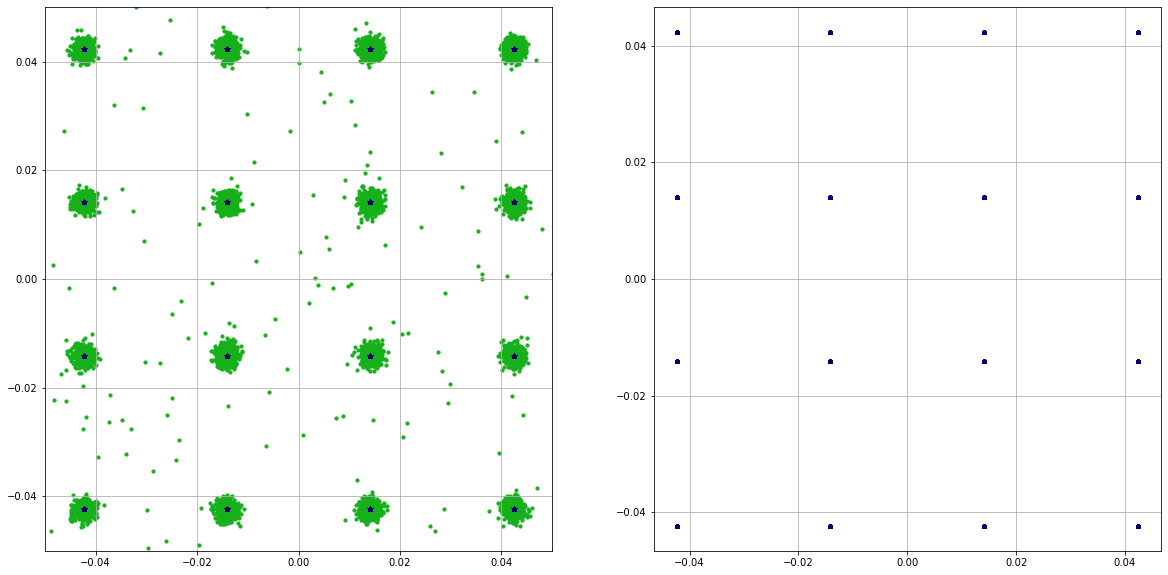

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_nft.real, points_nft.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points.real, points.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points.real, points.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)

array([-0.01542472-0.01388571j, -0.01299597-0.04382881j,
       -0.04272087+0.01457242j, ...,  0.03887724+0.01291907j,
        0.01397474+0.04371872j,  0.04275676+0.043137j  ])